In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# # Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [6]:
# # Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [7]:
# Import uuid library to generate unique image names
import uuid

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\61087a17-cd79-11ee-aadc-04ecd823af18.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [10]:
frame

array([[[198, 198, 198],
        [198, 198, 198],
        [197, 197, 197],
        ...,
        [186, 191, 189],
        [186, 191, 190],
        [186, 191, 190]],

       [[198, 198, 198],
        [197, 197, 197],
        [197, 197, 197],
        ...,
        [186, 191, 189],
        [186, 191, 190],
        [186, 191, 190]],

       [[198, 198, 198],
        [198, 198, 198],
        [197, 197, 197],
        ...,
        [186, 191, 189],
        [186, 191, 190],
        [185, 190, 189]],

       ...,

       [[ 37,  36,  69],
        [ 36,  34,  70],
        [ 37,  35,  71],
        ...,
        [ 23,  26,  38],
        [ 27,  29,  40],
        [ 25,  25,  34]],

       [[ 36,  35,  65],
        [ 36,  36,  66],
        [ 37,  37,  68],
        ...,
        [ 26,  23,  32],
        [ 26,  25,  29],
        [ 26,  26,  27]],

       [[ 37,  36,  66],
        [ 36,  36,  66],
        [ 37,  37,  68],
        ...,
        [ 26,  23,  32],
        [ 26,  25,  29],
        [ 25,  25,  26]]

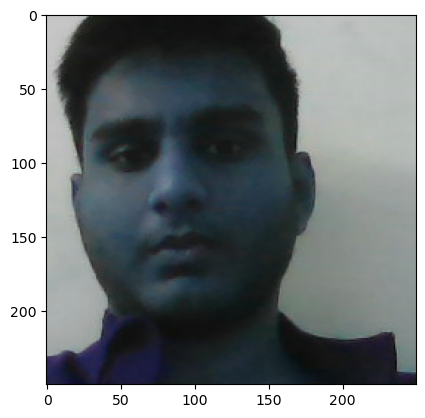

In [11]:
plt.imshow(frame)

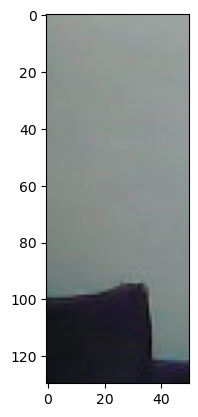

In [12]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
print(dir_test.next())

b'data\\anchor\\c4a694ce-c4f1-11ee-812e-04ecd823af18.jpg'


In [16]:
dir2_test = negative.as_numpy_iterator()

In [17]:
print(dir2_test.next())

b'data\\negative\\Gloria_Macapagal_Arroyo_0005.jpg'


In [18]:
dir3_test = positive.as_numpy_iterator()

In [19]:
print(dir3_test.next())

b'data\\positive\\a12aef72-c4f1-11ee-8d34-04ecd823af18.jpg'


In [20]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img 

In [21]:
img=preprocess('data\\anchor\\fffe37a9-c4f1-11ee-bbbd-04ecd823af18.jpg')

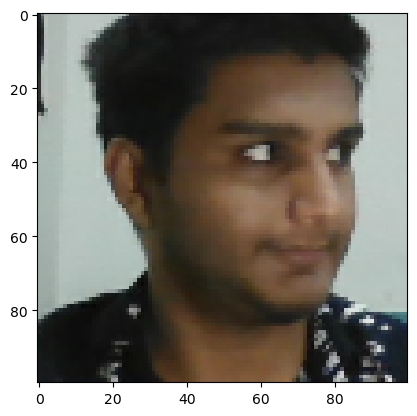

In [130]:
plt.imshow(img)

In [23]:
img2=preprocess('data\\negative\\Sergio_Vieira_De_Mello_0010.jpg')

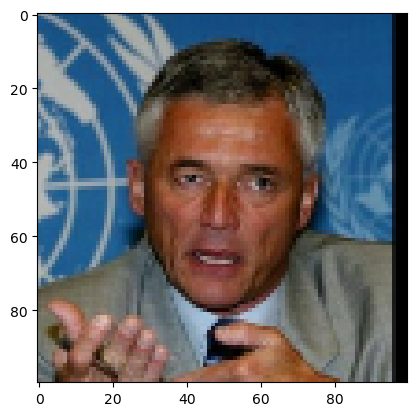

In [24]:
plt.imshow(img2)

In [25]:
img2.numpy().min()

0.0

In [26]:
img2.numpy().max()

0.88529414

In [27]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [28]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [29]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [30]:
samples = data.as_numpy_iterator()

In [31]:
example = samples.next()

In [32]:
example

(b'data\\anchor\\c5250097-c4f1-11ee-bb12-04ecd823af18.jpg',
 b'data\\positive\\bf580521-c4f1-11ee-9557-04ecd823af18.jpg',
 1.0)

In [33]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [34]:
res = preprocess_twin(*example)

In [92]:
res[1]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.12818627, 0.13210784, 0.13995098],
        [0.50171566, 0.5115196 , 0.50759804],
        [0.7531863 , 0.77181375, 0.7590686 ],
        ...,
        [0.14362745, 0.15980393, 0.15563725],
        [0.2379902 , 0.2637255 , 0.25514707],
        [0.40955883, 0.44828433, 0.43137255]],

       [[0.13455883, 0.1384804 , 0.14632353],
        [0.4007353 , 0.40980393, 0.40808824],
        [0.75171566, 0.76740193, 0.76348037],
        ...,
        [0.13161765, 0.13946079, 0.12965687],
        [0.1504902 , 0.16348039, 0.16176471],
        [0.17598039, 0.19093138, 0.19681373]],

       [[0.1115196 , 0.1242647 , 0.12916666],
        [0.31838235, 0.33186275, 0.3345588 ],
        [0.73137254, 0.7470588 , 0.74313724],
        ...,
        [0.10171568, 0.10808823, 0.09901961],
        [0.11519608, 0.11789215, 0.11838235],
        [0.11715686, 0.11813726, 0.12794118]],

       ...,

       [[0.18382353, 0.20931372, 0.25539216],
        [0.53

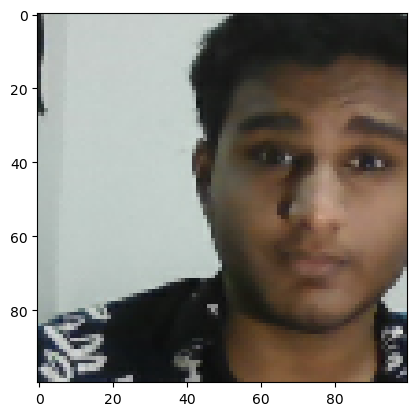

In [35]:
plt.imshow(res[1])

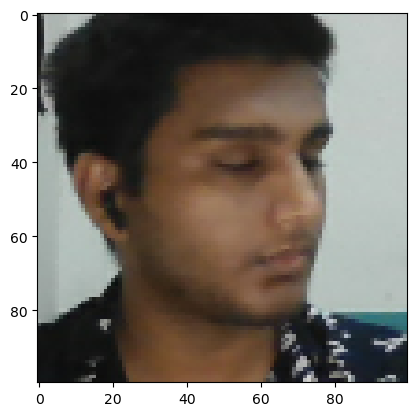

In [36]:
plt.imshow(res[0])

In [37]:
res[2]

1.0

In [38]:
# # Build dataloader pipeline
# data = data.map(preprocess_twin)

In [83]:
# data=data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [84]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [85]:
samples2 = data.as_numpy_iterator()

In [86]:
example = samples2.next()
example

(array([[[0.11691176, 0.12083333, 0.12867647],
         [0.46029413, 0.4759804 , 0.4779412 ],
         [0.6970588 , 0.71862745, 0.7058824 ],
         ...,
         [0.12941177, 0.12941177, 0.12941177],
         [0.13627452, 0.13627452, 0.14215687],
         [0.13455883, 0.13357843, 0.14436275]],
 
        [[0.10686275, 0.11078431, 0.11862745],
         [0.35343137, 0.3602941 , 0.36519608],
         [0.7051471 , 0.7252451 , 0.7147059 ],
         ...,
         [0.10857843, 0.10857843, 0.10073529],
         [0.10784314, 0.10784314, 0.10441177],
         [0.1125    , 0.1125    , 0.11053921]],
 
        [[0.12083333, 0.11887255, 0.13553922],
         [0.25784314, 0.2632353 , 0.26813725],
         [0.7171569 , 0.73137254, 0.72745097],
         ...,
         [0.0872549 , 0.0872549 , 0.07941177],
         [0.08431373, 0.08431373, 0.07647059],
         [0.09289216, 0.09583333, 0.07916667]],
 
        ...,
 
        [[0.6343137 , 0.64117646, 0.65392154],
         [0.55269605, 0.5654412 , 0.58308

In [87]:
len(example)

3

In [93]:
samp=samples2.next()

In [94]:
# samp

In [95]:
samp

(array([[[0.15833333, 0.15637255, 0.16519608],
         [0.48333332, 0.5004902 , 0.50171566],
         [0.7083333 , 0.7406863 , 0.7240196 ],
         ...,
         [0.51960784, 0.5357843 , 0.53161764],
         [0.7509804 , 0.78333336, 0.77254903],
         [0.75416666, 0.7894608 , 0.7776961 ]],
 
        [[0.11960784, 0.12279411, 0.13259804],
         [0.37941176, 0.40588236, 0.40490195],
         [0.70637256, 0.74313724, 0.73112744],
         ...,
         [0.17181373, 0.18259804, 0.16985294],
         [0.5865196 , 0.60906863, 0.59338236],
         [0.71642154, 0.7595588 , 0.7360294 ]],
 
        [[0.10073529, 0.11568628, 0.12769608],
         [0.29485294, 0.31764707, 0.32769608],
         [0.69240195, 0.73137254, 0.72745097],
         ...,
         [0.12916666, 0.13112745, 0.12230392],
         [0.19313726, 0.21053922, 0.20147058],
         [0.6644608 , 0.6936275 , 0.6818628 ]],
 
        ...,
 
        [[0.81078434, 0.82965684, 0.8063725 ],
         [0.59289217, 0.61764705, 0.61323

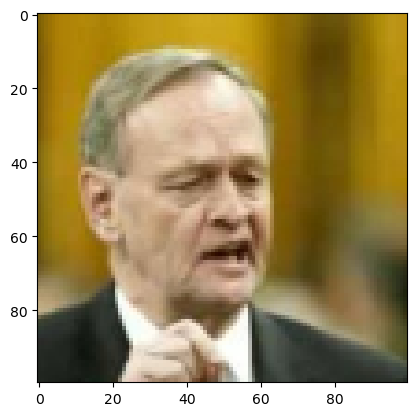

In [96]:
plt.imshow(samp[1])

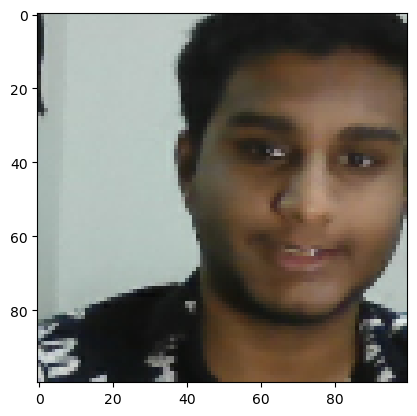

In [97]:
plt.imshow(samp[0])

In [98]:
samp[2]

0.0

In [153]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [61]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [62]:
train_samples=train_data.as_numpy_iterator()

In [63]:
train_sam=train_samples.next()

In [64]:
len(train_sam[0])

16

In [175]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# embedding layer

In [104]:
inp = Input(shape=(105,105,3), name='input_image')

In [105]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [106]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [107]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d_1')>

In [108]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [109]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [110]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [111]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [112]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [115]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [113]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [114]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 128)       26

In [116]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [117]:
embedding = make_embedding()

In [118]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 128)       26

# distance layer

In [119]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [120]:
l1 = L1Dist()

# siamese model

In [121]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [122]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [123]:
siamese_layer = L1Dist()

In [124]:
distances = siamese_layer(inp_embedding, val_embedding)

In [125]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [126]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [127]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [128]:
siamese_model = make_siamese_model()


In [132]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# training

In [155]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [156]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [157]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [158]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]


In [159]:
X

(array([[[[0.10931373, 0.12107843, 0.14411765],
          [0.44093138, 0.4612745 , 0.4735294 ],
          [0.6982843 , 0.73333335, 0.7323529 ],
          ...,
          [0.75686276, 0.78039217, 0.77254903],
          [0.7529412 , 0.7764706 , 0.76862746],
          [0.75686276, 0.78039217, 0.77254903]],
 
         [[0.10857843, 0.12058824, 0.13480392],
          [0.32647058, 0.34411764, 0.3514706 ],
          [0.6985294 , 0.7286765 , 0.725     ],
          ...,
          [0.75686276, 0.78039217, 0.77254903],
          [0.75686276, 0.78039217, 0.77254903],
          [0.75514704, 0.77867645, 0.7708333 ]],
 
         [[0.10612745, 0.11004902, 0.11838235],
          [0.2497549 , 0.26544118, 0.2634804 ],
          [0.70098037, 0.7230392 , 0.71593136],
          ...,
          [0.75759804, 0.78112745, 0.7732843 ],
          [0.75980395, 0.78333336, 0.7754902 ],
          [0.7558824 , 0.7794118 , 0.77156866]],
 
         ...,
 
         [[0.0872549 , 0.09705883, 0.12254902],
          [0.08039

In [160]:
y

array([0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

In [161]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [162]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [166]:

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [164]:
EPOCHS = 50

In [165]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 33s 1s/step
0.2804377 0.7178218 1.0

 Epoch 2/50
27/27 [==============================] - 32s 1s/step
0.26701817 0.9238095 0.9948718

 Epoch 3/50
27/27 [==============================] - 35s 1s/step
0.029833278 0.9724771 1.0

 Epoch 4/50
27/27 [==============================] - 33s 1s/step
0.17169099 0.98536587 1.0

 Epoch 5/50
27/27 [==============================] - 32s 1s/step
0.10314042 0.98578197 1.0

 Epoch 6/50
1/1 [==============================] - 0s 309ms/step


27/27 [==============================] - 33s 1s/step
0.013900137 0.93532336 0.9791667

 Epoch 7/50
27/27 [==============================] - 30s 1s/step
0.0018610075 0.97652584 1.0

 Epoch 8/50
27/27 [==============================] - 31s 1s/step
0.00376173 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 31s 1s/step
0.5781055 0.99065423 1.0

 Epoch 10/50
27/27 [==============================] - 31s 1s/step
0.008039323 0.99526066 1.0

 Epoch 11/50
1/1 [==============================] - 0s 278ms/step


27/27 [==============================] - 31s 1s/step
0.008801732 1.0 1.0

 Epoch 12/50
27/27 [==============================] - 31s 1s/step
0.0007309731 1.0 1.0

 Epoch 13/50
27/27 [==============================] - 31s 1s/step
0.008963611 1.0 1.0

 Epoch 14/50
27/27 [==============================] - 32s 1s/step
0.00018587505 1.0 1.0

 Epoch 15/50
27/27 [==============================] - 31s 1s/step
3.08175e-05 1.0 1.0

 Epoch 16/50
1/1 [==============================] - 0s 277ms/step


27/27 [==============================] - 32s 1s/step
0.0038217837 1.0 1.0

 Epoch 17/50
27/27 [==============================] - 31s 1s/step
0.0010788483 1.0 1.0

 Epoch 18/50
27/27 [==============================] - 31s 1s/step
4.1872504e-06 1.0 1.0

 Epoch 19/50
27/27 [==============================] - 30s 1s/step
1.7017504e-05 1.0 1.0

 Epoch 20/50
27/27 [==============================] - 31s 1s/step
0.0006872914 1.0 1.0

 Epoch 21/50
27/27 [==============================] - 32s 1s/step
8.9406974e-08 1.0 1.0

 Epoch 22/50
1/1 [==============================] - 0s 251ms/step


27/27 [==============================] - 31s 1s/step
0.00028361834 1.0 1.0

 Epoch 23/50
27/27 [==============================] - 31s 1s/step
0.0009885243 1.0 1.0

 Epoch 24/50
27/27 [==============================] - 33s 1s/step
0.00026318867 1.0 1.0

 Epoch 25/50
27/27 [==============================] - 39s 1s/step
2.9802326e-08 1.0 1.0

 Epoch 26/50
27/27 [==============================] - 38s 1s/step
4.8537793e-05 1.0 1.0

 Epoch 27/50
1/1 [==============================] - 0s 392ms/step


27/27 [==============================] - 38s 1s/step
0.00011376824 1.0 1.0

 Epoch 28/50
27/27 [==============================] - 42s 2s/step
0.0003644499 1.0 1.0

 Epoch 29/50
27/27 [==============================] - 38s 1s/step
3.7849152e-06 1.0 1.0

 Epoch 30/50
27/27 [==============================] - 40s 2s/step
2.5750398e-05 1.0 1.0

 Epoch 31/50
27/27 [==============================] - 39s 1s/step
3.9356786e-05 1.0 1.0

 Epoch 32/50
27/27 [==============================] - 42s 2s/step
3.2710188e-05 1.0 1.0

 Epoch 33/50
1/1 [==============================] - 0s 433ms/step


27/27 [==============================] - 39s 1s/step
0.0 1.0 1.0

 Epoch 34/50
27/27 [==============================] - 36s 1s/step
2.8567152e-05 1.0 1.0

 Epoch 35/50
27/27 [==============================] - 36s 1s/step
0.00011288115 1.0 1.0

 Epoch 36/50
27/27 [==============================] - 37s 1s/step
0.00036831442 1.0 1.0

 Epoch 37/50
27/27 [==============================] - 37s 1s/step
2.7464348e-05 1.0 1.0

 Epoch 38/50
1/1 [==============================] - 0s 335ms/step


27/27 [==============================] - 43s 2s/step
3.0041852e-05 1.0 1.0

 Epoch 39/50
27/27 [==============================] - 37s 1s/step
7.450582e-08 1.0 1.0

 Epoch 40/50
27/27 [==============================] - 37s 1s/step
4.8582046e-05 1.0 1.0

 Epoch 41/50
27/27 [==============================] - 33s 1s/step
2.9802326e-08 1.0 1.0

 Epoch 42/50
27/27 [==============================] - 30s 1s/step
0.00027422438 1.0 1.0

 Epoch 43/50
1/1 [==============================] - 0s 271ms/step


27/27 [==============================] - 30s 1s/step
7.630559e-05 1.0 1.0

 Epoch 44/50
27/27 [==============================] - 30s 1s/step
5.640706e-05 1.0 1.0

 Epoch 45/50
27/27 [==============================] - 30s 1s/step
0.00037425436 1.0 1.0

 Epoch 46/50
27/27 [==============================] - 6843s 263s/step
1.6332206e-05 1.0 1.0

 Epoch 47/50
27/27 [==============================] - 5258s 202s/step
0.00021801952 1.0 1.0

 Epoch 48/50
27/27 [==============================] - 38s 1s/step
0.00026808144 1.0 1.0

 Epoch 49/50
1/1 [==============================] - 0s 418ms/step


27/27 [==============================] - 45s 2s/step
0.0003458119 1.0 1.0

 Epoch 50/50
27/27 [==============================] - 42s 2s/step
0.00017145193 1.0 1.0


# evaluate model

In [291]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [292]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [293]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 280ms/step


In [294]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]

In [295]:
y_true

array([0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

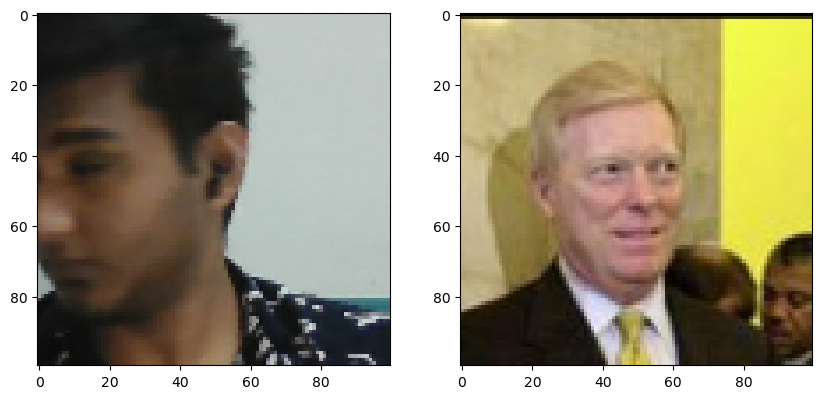

In [299]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [288]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [289]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [338]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 129ms/step
1.0 1.0


In [300]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [301]:
 # Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [302]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 352ms/step


array([[9.9041584e-09],
       [1.0000000e+00],
       [9.9915749e-01],
       [7.5992004e-09],
       [2.3256033e-10],
       [1.1340368e-08],
       [9.9999923e-01],
       [1.0000000e+00],
       [9.9988472e-01],
       [1.0000000e+00],
       [6.3450135e-12],
       [6.6935456e-08],
       [2.1632936e-06],
       [1.8116111e-09],
       [1.2174290e-07],
       [9.9999946e-01]], dtype=float32)

In [303]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# real time test

In [306]:

# application_data\verification_images

In [308]:
os.listdir(os.path.join('application_data', 'verification_images'))

['000c93c4-c4f2-11ee-b4cf-04ecd823af18.jpg',
 '00a310a4-c4f2-11ee-abfe-04ecd823af18.jpg',
 '00a7d8a6-c4f2-11ee-8141-04ecd823af18.jpg',
 '00b89a8f-c4f2-11ee-a8c0-04ecd823af18.jpg',
 'a08517da-c4f1-11ee-a411-04ecd823af18.jpg',
 'a1116c0b-c4f1-11ee-a60f-04ecd823af18.jpg',
 'a1166523-c4f1-11ee-9fc0-04ecd823af18.jpg',
 'a2621ebe-c4f1-11ee-868b-04ecd823af18.jpg',
 'a2672271-c4f1-11ee-b676-04ecd823af18.jpg',
 'a2764e22-c4f1-11ee-8791-04ecd823af18.jpg',
 'a2805b6d-c4f1-11ee-a078-04ecd823af18.jpg',
 'a2855fac-c4f1-11ee-86f3-04ecd823af18.jpg',
 'a2947ce5-c4f1-11ee-a57b-04ecd823af18.jpg',
 'a3043d08-c4f1-11ee-b245-04ecd823af18.jpg',
 'a3095666-c4f1-11ee-b80f-04ecd823af18.jpg',
 'a3135309-c4f1-11ee-9e1c-04ecd823af18.jpg',
 'a3188b6b-c4f1-11ee-8584-04ecd823af18.jpg',
 'a3734e13-c4f1-11ee-b62e-04ecd823af18.jpg',
 'a3829a1f-c4f1-11ee-81a2-04ecd823af18.jpg',
 'a4048a83-c4f1-11ee-913a-04ecd823af18.jpg',
 'a4190d31-c4f1-11ee-a02c-04ecd823af18.jpg',
 'a43283ea-c4f1-11ee-8fbd-04ecd823af18.jpg',
 'a437842f

In [309]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [311]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
    print(validation_img)

tf.Tensor(
[[[0.12622549 0.14583333 0.1615196 ]
  [0.44705883 0.48039216 0.49117646]
  [0.69289213 0.7321078  0.7362745 ]
  ...
  [0.7512255  0.7943627  0.77867645]
  [0.7512255  0.7884804  0.7757353 ]
  [0.7519608  0.7872549  0.7754902 ]]

 [[0.10147059 0.11642157 0.1264706 ]
  [0.360049   0.39534312 0.39142156]
  [0.70441175 0.7441176  0.7375    ]
  ...
  [0.75392157 0.7892157  0.777451  ]
  [0.75392157 0.7892157  0.777451  ]
  [0.7588235  0.7911765  0.78039217]]

 [[0.11764706 0.12083333 0.12867647]
  [0.2752451  0.30171567 0.29436275]
  [0.70343137 0.74019605 0.72769606]
  ...
  [0.7627451  0.7892157  0.78039217]
  [0.7627451  0.7892157  0.78039217]
  [0.76862746 0.7921569  0.78431374]]

 ...

 [[0.09803922 0.11372549 0.1254902 ]
  [0.0872549  0.1        0.1127451 ]
  [0.09313726 0.09705883 0.10833333]
  ...
  [0.09117647 0.1245098  0.15294118]
  [0.09338235 0.12083333 0.15612745]
  [0.09117647 0.1245098  0.15882353]]

 [[0.1002451  0.10710784 0.12181372]
  [0.09338235 0.10171568 0

In [316]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# access webcam


In [340]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 73ms/step
False
1/1 [==============================] - 0s 50ms/step
False
1/1 [==============================] - 0s 47ms/step
True
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 50ms/step
True
1/1 [==============================] - 0s 47ms/step
True


In [335]:
results

[array([[0.9996236]], dtype=float32),
 array([[0.9994332]], dtype=float32),
 array([[0.97351855]], dtype=float32),
 array([[0.89328563]], dtype=float32),
 array([[0.00137771]], dtype=float32),
 array([[0.0488887]], dtype=float32),
 array([[0.61071944]], dtype=float32),
 array([[0.00141381]], dtype=float32),
 array([[0.00159563]], dtype=float32),
 array([[0.00464966]], dtype=float32),
 array([[0.00600847]], dtype=float32),
 array([[0.00853873]], dtype=float32),
 array([[0.0030862]], dtype=float32),
 array([[0.9972381]], dtype=float32),
 array([[0.99933165]], dtype=float32),
 array([[0.85675627]], dtype=float32),
 array([[0.38333952]], dtype=float32),
 array([[0.14779238]], dtype=float32),
 array([[0.00265315]], dtype=float32),
 array([[0.02168711]], dtype=float32),
 array([[0.00113146]], dtype=float32),
 array([[0.00097399]], dtype=float32),
 array([[0.00118412]], dtype=float32),
 array([[0.00119046]], dtype=float32),
 array([[0.9999998]], dtype=float32),
 array([[0.001373]], dtype=floa

In [341]:
np.sum(np.squeeze(results) > 0.5)

31